<a href="https://colab.research.google.com/github/swguo/pyspark-env-setup/blob/master/PySpark_for_Machine_Learning_on_the_Iris_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

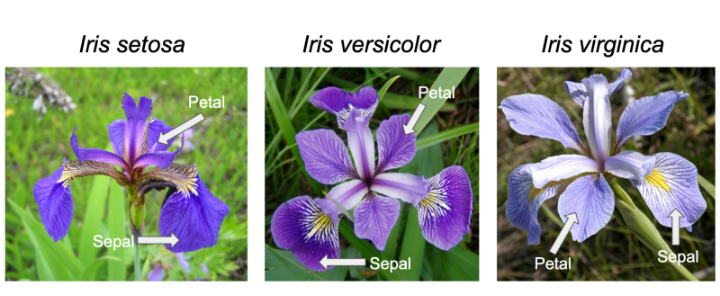

安德森鳶尾花卉數據集（英文：Anderson's Iris data set）

一、150筆資料

二、三種花的品種(target): setosa(0)、versicolor(1)、virginica(2)

三、四個特徵（feature）:

* sepal length(花萼長度)
* sepal width(花萼寬度)
* Petal length(花瓣長度)
* Petal width(花瓣寬度)

## 環境準備

### 安裝必要的環境

In [1]:
!pip install pyspark


In [2]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.datasets import load_iris
import pandas as pd
from pyspark.sql import SparkSession

### 建立 PySpark Session：

In [3]:
# 初始化 Spark Session
spark = SparkSession.builder \
    .appName("Iris Decision Tree Classification") \
    .getOrCreate()

## 資料導入與探索

### 載入 Iris Dataset：

In [4]:
iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['label'] = iris.target

# 將 Pandas DataFrame 轉為 Spark DataFrame
iris_df = spark.createDataFrame(df)
iris_df.show(5)


+-----------------+----------------+-----------------+----------------+-----+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|label|
+-----------------+----------------+-----------------+----------------+-----+
|              5.1|             3.5|              1.4|             0.2|    0|
|              4.9|             3.0|              1.4|             0.2|    0|
|              4.7|             3.2|              1.3|             0.2|    0|
|              4.6|             3.1|              1.5|             0.2|    0|
|              5.0|             3.6|              1.4|             0.2|    0|
+-----------------+----------------+-----------------+----------------+-----+
only showing top 5 rows



### 確認數據分佈與摘要統計：

In [5]:
iris_df.describe().show()


+-------+------------------+------------------+------------------+------------------+------------------+
|summary| sepal length (cm)|  sepal width (cm)| petal length (cm)|  petal width (cm)|             label|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|               150|               150|               150|               150|               150|
|   mean| 5.843333333333332|3.0573333333333337| 3.758000000000001|1.1993333333333331|               1.0|
| stddev|0.8280661279778628|0.4358662849366982|1.7652982332594664|0.7622376689603467|0.8192319205190403|
|    min|               4.3|               2.0|               1.0|               0.1|                 0|
|    max|               7.9|               4.4|               6.9|               2.5|                 2|
+-------+------------------+------------------+------------------+------------------+------------------+



## 數據分析 : 觀察特徵的分佈

In [6]:
# 建立 Pandas DataFrame
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['species'] = pd.Categorical.from_codes(iris.target, categories=iris.target_names)

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
# 設定 Seaborn 圖形樣式
sns.set(style="whitegrid")

### 繪製直方圖，檢視特徵分佈

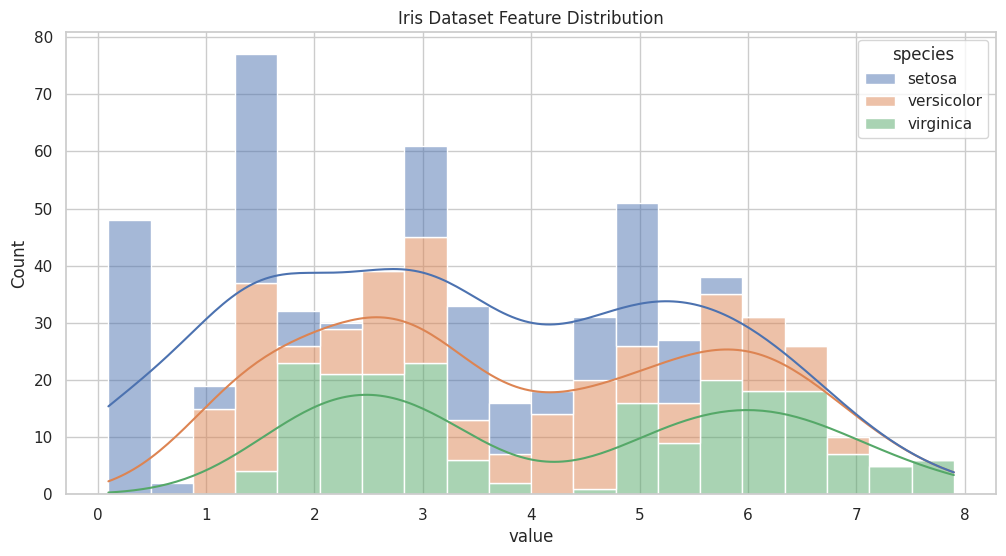

In [8]:
# 繪製直方圖，檢視特徵分佈
df_melt = pd.melt(df, id_vars="species", var_name="feature", value_name="value")
plt.figure(figsize=(12, 6))
sns.histplot(data=df_melt, x="value", hue="species", multiple="stack", kde=True, bins=20)
plt.title("Iris Dataset Feature Distribution")
plt.show()

### 繪製箱型圖，檢視每個特徵的數據範圍與離群點

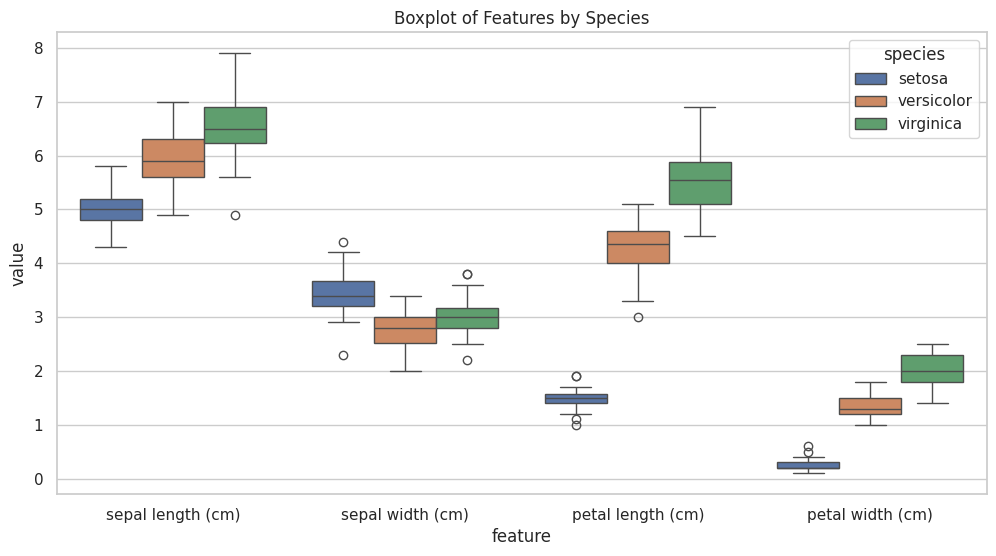

In [9]:
# 繪製箱型圖，檢視每個特徵的數據範圍與離群點
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_melt, x="feature", y="value", hue="species")
plt.title("Boxplot of Features by Species")
plt.show()

### 檢查特徵與類別的關係

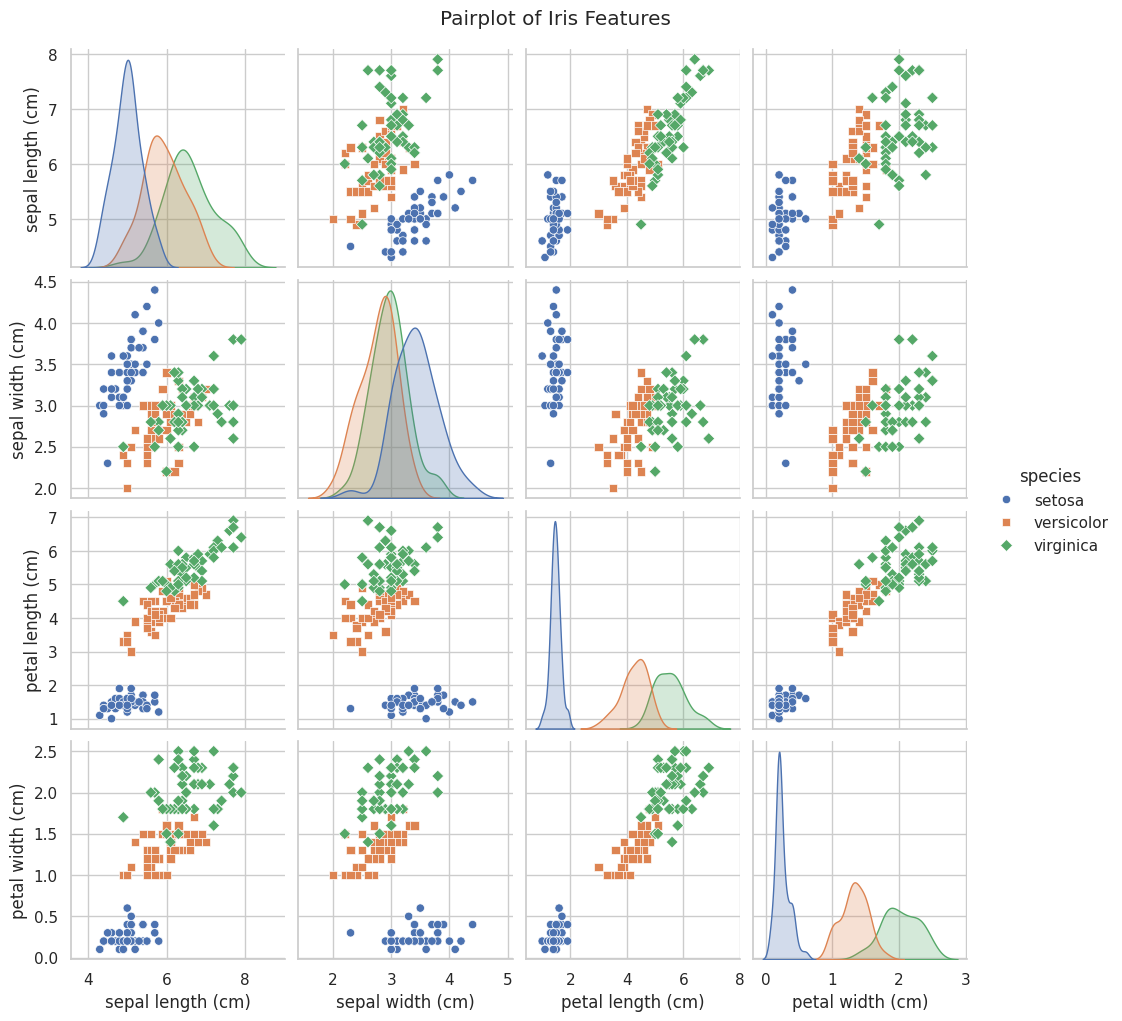

In [10]:
# 繪製散佈圖矩陣
sns.pairplot(df, hue="species", diag_kind="kde", markers=["o", "s", "D"])
plt.suptitle("Pairplot of Iris Features", y=1.02)
plt.show()


In [11]:
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


## 資料分割：將數據集劃分為訓練集與測試集：

In [12]:
from pyspark.ml.feature import VectorAssembler

feature_cols = iris.feature_names
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
iris_features_df = assembler.transform(iris_df)
iris_features_df.show(5)


+-----------------+----------------+-----------------+----------------+-----+-----------------+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|label|         features|
+-----------------+----------------+-----------------+----------------+-----+-----------------+
|              5.1|             3.5|              1.4|             0.2|    0|[5.1,3.5,1.4,0.2]|
|              4.9|             3.0|              1.4|             0.2|    0|[4.9,3.0,1.4,0.2]|
|              4.7|             3.2|              1.3|             0.2|    0|[4.7,3.2,1.3,0.2]|
|              4.6|             3.1|              1.5|             0.2|    0|[4.6,3.1,1.5,0.2]|
|              5.0|             3.6|              1.4|             0.2|    0|[5.0,3.6,1.4,0.2]|
+-----------------+----------------+-----------------+----------------+-----+-----------------+
only showing top 5 rows



In [13]:
train_df, test_df = iris_features_df.randomSplit([0.8, 0.2], seed=42)


In [14]:
# 儲存數據集到 Parquet 格式
train_df.write.mode("overwrite").parquet("data/train_data.parquet")
test_df.write.mode("overwrite").parquet("data/test_data.parquet")
print("Train and Test datasets saved as Parquet.")

Train and Test datasets saved as Parquet.


## 模型訓練

### 建立 Decision Tree 模型 & 訓練

In [15]:
from pyspark.ml.classification import DecisionTreeClassifier

# 建立 Decision Tree 模型
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label", maxDepth=5)

# 模型訓練
dt_model = dt.fit(train_df)

In [16]:
model_path = './model'
dt_model.write().overwrite().save(model_path)
print(f"Model saved to {model_path}")

Model saved to ./model


## 預測

### 載入模型

In [17]:
from pyspark.ml.classification import DecisionTreeClassificationModel
# 載入模型
loaded_model = DecisionTreeClassificationModel.load(model_path)
print("Model successfully loaded.")

Model successfully loaded.


In [18]:
# 重新讀取數據集
train_df = spark.read.parquet("data/train_data.parquet")
test_df = spark.read.parquet("data/test_data.parquet")

In [19]:
# 預測
predictions = loaded_model.transform(test_df)

# 查看預測結果
predictions.select("features", "label", "prediction").show()
predictions.select("label", "prediction").write.csv("iris_predictions.csv", header=True)

+-----------------+-----+----------+
|         features|label|prediction|
+-----------------+-----+----------+
|[4.9,2.5,4.5,1.7]|    2|       1.0|
|[5.5,2.4,3.8,1.1]|    1|       1.0|
|[5.5,2.5,4.0,1.3]|    1|       1.0|
|[5.7,2.9,4.2,1.3]|    1|       1.0|
|[5.8,2.7,5.1,1.9]|    2|       2.0|
|[5.9,3.0,5.1,1.8]|    2|       2.0|
|[6.2,3.4,5.4,2.3]|    2|       2.0|
|[6.3,2.7,4.9,1.8]|    2|       2.0|
|[6.3,2.9,5.6,1.8]|    2|       2.0|
|[6.5,3.0,5.2,2.0]|    2|       2.0|
|[6.5,3.2,5.1,2.0]|    2|       2.0|
|[6.7,3.3,5.7,2.1]|    2|       2.0|
|[6.7,3.3,5.7,2.5]|    2|       2.0|
|[6.8,3.2,5.9,2.3]|    2|       2.0|
|[6.9,3.1,5.1,2.3]|    2|       2.0|
|[7.4,2.8,6.1,1.9]|    2|       2.0|
|[4.4,3.0,1.3,0.2]|    0|       0.0|
|[4.6,3.2,1.4,0.2]|    0|       0.0|
|[4.6,3.6,1.0,0.2]|    0|       0.0|
|[4.8,3.1,1.6,0.2]|    0|       0.0|
+-----------------+-----+----------+
only showing top 20 rows



## 評估

In [20]:
predictions_df = spark.read.csv("iris_predictions.csv", header=True, inferSchema=True)

# 查看預測結果
predictions_df.show()

+-----+----------+
|label|prediction|
+-----+----------+
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    1|       1.0|
|    0|       0.0|
|    1|       1.0|
|    1|       1.0|
|    2|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
+-----+----------+
only showing top 20 rows



In [21]:
# 評估模型
evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions_df)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.96875


In [22]:
# 獲取標籤與預測值
labels = predictions_df.select("label").rdd.flatMap(lambda x: x).collect()
predictions = predictions_df.select("prediction").rdd.flatMap(lambda x: x).collect()

# 計算混淆矩陣
from sklearn.metrics import confusion_matrix, classification_report
conf_matrix = confusion_matrix(labels, predictions)

# 打印混淆矩陣
print("Confusion Matrix:")
print(conf_matrix)

# 打印分類報告
print("\nClassification Report:")
print(classification_report(labels, predictions))

Confusion Matrix:
[[13  0  0]
 [ 0  6  0]
 [ 0  1 12]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.86      1.00      0.92         6
           2       1.00      0.92      0.96        13

    accuracy                           0.97        32
   macro avg       0.95      0.97      0.96        32
weighted avg       0.97      0.97      0.97        32



## 可視化模型

In [23]:
!pip install graphviz

In [24]:

from graphviz import Digraph

In [25]:
# 載出決策樹規則
tree_rules = dt_model.toDebugString
print(tree_rules)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_6dd78c96a4ab, depth=5, numNodes=15, numClasses=3, numFeatures=4
  If (feature 2 <= 2.45)
   Predict: 0.0
  Else (feature 2 > 2.45)
   If (feature 3 <= 1.75)
    If (feature 2 <= 4.95)
     Predict: 1.0
    Else (feature 2 > 4.95)
     If (feature 3 <= 1.55)
      Predict: 2.0
     Else (feature 3 > 1.55)
      If (feature 0 <= 6.75)
       Predict: 1.0
      Else (feature 0 > 6.75)
       Predict: 2.0
   Else (feature 3 > 1.75)
    If (feature 2 <= 4.85)
     If (feature 0 <= 5.95)
      Predict: 1.0
     Else (feature 0 > 5.95)
      Predict: 2.0
    Else (feature 2 > 4.85)
     Predict: 2.0



In [26]:
def parse_tree(tree_rules):
    lines = tree_rules.split("\n")  # 拆分樹的每一行
    graph = Digraph()  # 初始化 Graphviz 圖形對象
    stack = []  # 用於存儲節點的層次結構

    for line in lines:
        # 計算縮排數量以確定層級
        indent = len(line) - len(line.lstrip())
        content = line.strip()

        if "If" in content:  # 判斷條件節點
            condition = content.split("If ")[1]  # 提取條件
            node_id = f"node{len(stack)}"  # 節點 ID，唯一
            graph.node(node_id, condition)  # 新增節點

            # 如果有父節點，建立連接
            if stack:
                parent_id, branch = stack[-1]  # 從堆疊中取得父節點 ID
                graph.edge(parent_id, node_id, label="True" if branch == "True" else "False")

            # 將當前節點加入堆疊，等待子節點連接
            stack.append((node_id, "True"))

        elif "Else" in content:  # 判斷 "Else" 節點
            # 修改堆疊的狀態為 "False" 分支
            if stack:
                stack[-1] = (stack[-1][0], "False")

        elif "Predict" in content:  # 預測結果節點
            prediction = content.split("Predict: ")[1]  # 提取預測值
            node_id = f"node{len(stack)}"
            graph.node(node_id, f"Predict: {prediction}")  # 新增節點

            # 如果有父節點，建立連接
            if stack:
                parent_id, branch = stack[-1]
                graph.edge(parent_id, node_id, label="True" if branch == "True" else "False")

            # 子節點處理完畢後，移除堆疊
            if stack:
                stack.pop()

    return graph

# 呼叫函式來繪製樹
tree_graph = parse_tree(tree_rules)
tree_graph.render("decision_tree", format="png", cleanup=True)  # 產生 PNG 檔案


'decision_tree.png'

## 部屬模型

In [27]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


### 取得對應的標籤名稱

In [28]:
# 取得對應的標籤名稱
label_mapping = {index: name for index, name in enumerate(iris.target_names)}

### 定義預測函式

In [29]:
import gradio as gr
# 定義預測函式
def predict_species(sepal_length, sepal_width, petal_length, petal_width):
    # 創建輸入數據框架
    input_data = pd.DataFrame({
        'sepal length (cm)': [sepal_length],
        'sepal width (cm)': [sepal_width],
        'petal length (cm)': [petal_length],
        'petal width (cm)': [petal_width],
    })

    # 轉換為 Spark DataFrame 並應用 VectorAssembler
    input_sdf = spark.createDataFrame(input_data)
    input_features = assembler.transform(input_sdf)

    # 預測
    prediction = dt_model.transform(input_features)
    predicted_label = prediction.collect()[0]['prediction']

    # 返回對應的標籤名稱
    return label_mapping[predicted_label]

In [30]:
# 設定 Gradio 介面
inputs = [
    gr.Number(label="Sepal Length (cm)", value=5.1),  # 使用 gr.Number，`value` 表示預設值
    gr.Number(label="Sepal Width (cm)", value=3.5),
    gr.Number(label="Petal Length (cm)", value=1.4),
    gr.Number(label="Petal Width (cm)", value=0.2),
]

outputs = gr.Textbox(label="Predicted Species")  # 使用 gr.Textbox 來顯示結果

### 建立 Gradio Interface

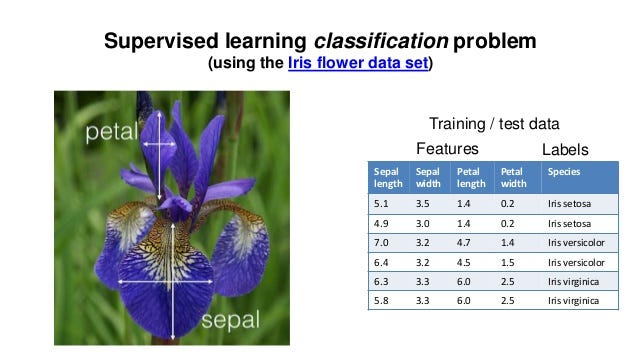

In [31]:
# 建立 Gradio Interface
gr.Interface(
    fn=predict_species,
    inputs=inputs,
    outputs=outputs,
    title="Iris Species Predictor",
    description="輸入花萼與花瓣的長度與寬度，預測 Iris 的種類（Setosa, Versicolor, Virginica）。"
).launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5b21bfe0f9e40615d4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
